# Intergroup Difference Explanations

This notebook shows how to produce intergroup difference explanations with general SHAP values.

In this example, we ask why our model predicts higher rates of two-year recidivism for Black criminals than for criminals of other races. We find that prior convictions, age, and race are the most important variables.

This question is a specific example of a general question. Suppose we have two groups of observations, 0 and 1, and a distance measure $d(\hat{y_0},\hat{y_1})$ of how different our model output is for each group. For a sample of observations $x$, we can ask why our model makes different predictions for different groups.

Here, groups 0 and 1 are non-Black and Black criminals, the model output is a classification which indicates that a criminal will recidivate within two years, and the distance measure is the relative difference in recidivism rates.

In [1]:
import gshap
from gshap.datasets import load_recidivism
from gshap.intergroup import IntergroupDifference, relative_mean_distance

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

We begin by loading the recidivism dataset (courtesy of Propublica's COMPAS analysis) and training our classifier.

In [2]:
recidivism = load_recidivism()
X, y = recidivism.data, recidivism.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000)
clf = SVC()
clf.fit(X_train, y_train)
print('Test score: %.4f' % clf.score(X_test, y_test))

Test score: 0.6460


Next, we compute summary statistics. We see that the predicted recidivism rate is higher for Black criminals than for criminals of other races.

Predicted two-year recidivism rate for non-Blacks:  0.40
Predicted two-year recidivism rate for Blacks:  0.62
Relative difference:  0.54


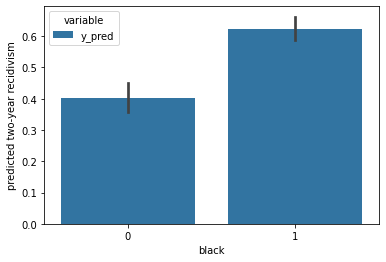

In [3]:
df = pd.concat((X_test, y_test), axis=1)
df['y_pred'] = clf.predict(X_test)
p_non_black, p_black = df.groupby('black')['y_pred'].mean()
print('Predicted two-year recidivism rate for non-Blacks: % .2f' % p_non_black)
print('Predicted two-year recidivism rate for Blacks: % .2f' % p_black)
print('Relative difference: % .2f' % (p_black/p_non_black - 1))

df['id'] = df.index
df = df.melt(('id', 'black'), value_vars='y_pred')
sns.barplot(y='value', x='black', hue='variable', data=df)
plt.ylabel('predicted two-year recidivism')
plt.show()

Here, we plot the correlations between each variable in our dataset and race and (actual) two-year recidivism.

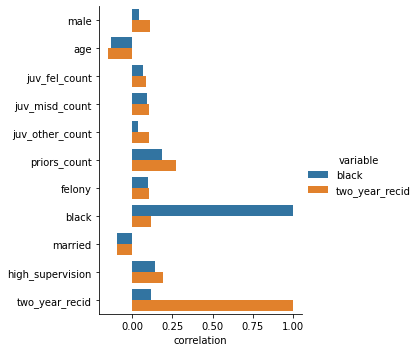

In [4]:
corr_df = recidivism.df.corr().reset_index()
corr_df = corr_df.melt('index', value_vars=('black', 'two_year_recid'))
sns.catplot(
    x='value',
    y='index',
    hue='variable',
    data=corr_df,
    kind='bar',
    orient='h'
)
plt.xlabel('correlation')
plt.ylabel('')
plt.show()

Compute the G-SHAP values, where $g$ is `IntergroupDifference`. `IntergroupDifference` measures the distance $d$ between our model's predictions for outgroup and ingroup observations.

Here, the outgroup and ingroup are non-Black and Black criminals. Our distance measure $d$ is the relative difference between group means; in this case, the relative difference in predicted recidivism rates.

In [5]:
g = IntergroupDifference(group=X_test['black'], distance=relative_mean_distance)
explainer = gshap.KernelExplainer(clf.predict, X_train, g)
gshap_values = explainer.gshap_values(X_test, nsamples=32)

For interpretation, we compare our test data to the shuffled background data in terms of $g$.

We see that there is a high relative mean difference in our test data. By contrast, there is 0 relative mean difference in the shuffled background data, as expected. Because each variable in the background data is shuffled, the model has no means of statistically discriminating between Black and non-Black criminals.

The sum of the G-SHAP values should approximately equal the relative differnce in predicted recidivism rates between non-Black and Black criminals in the test data (allowing for sampling error).

In [ ]:
g_comparison, g_background = explainer.compare(X_test, bootstrap_samples=1000)
print('Relative mean difference for test data: %.4f' % g_comparison)
print('Relative mean difference for (shuffled) background data: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values.sum())

Finally, we plot our results. This plot tells us which variables explain the relative difference in predicted recidivism rates between Black and non-Black criminals. 

More precisely, our model predicts that Black criminals are $p$ percent more likely to recidivate than criminals of other races. Each G-SHAP value $\phi_j$ is the number of percentage points of $p$ explained by feature $j$.

In [ ]:
df = pd.DataFrame({'Variable': X.columns, 'G-SHAP': gshap_values})
df = df.sort_values('G-SHAP', ascending=False).reset_index(drop=True)
sns.barplot(y='Variable', x='G-SHAP', data=df)
plt.show()